In [1]:
import pandas as pd
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import LeaveOneOut
from collections import Counter
import seaborn


%matplotlib inline

In [2]:
data_cam_df = pd.read_csv('xcms_pigs_camera.csv', sep = ',', index_col=0)

In [3]:
service_cols = ["mz", "mzmin", "mzmax", "rt", "rtmin", "rtmax", ".", "npeaks", "isotopes", "adduct", "pcgroup"]
assert len(set(service_cols) - set(data_cam_df.columns))==0
samples_cols = list(set(data_cam_df.columns) - set(service_cols))

In [4]:
data_cam_df[data_cam_df==0]=np.nan
data_cam_df[samples_cols] = np.log(data_cam_df[samples_cols])

## standards

#### TAG

In [5]:
new_mz_palm = np.abs((data_cam_df['mz'] - 811.765)) / 811.765 
new_mz_palm = new_mz_palm * 1000000
sunf_ppm_palm = data_cam_df[new_mz_palm<13]

In [6]:
sunf_ppm_palm.head()
sunf_ppm_palm.index

Int64Index([2011], dtype='int64')

In [7]:
RO=pd.Series([i.split('_')[3][1:] if 'S' in i else i for i in data_cam_df.columns],index=data_cam_df.columns)

In [8]:
for i in RO.index:
    try:
        RO[i]=int(RO[i])
    except:
        RO[i]=np.nan

In [9]:
RO=RO.dropna()

In [10]:
rt_in_min = data_cam_df['rt']/60
data_cam_df['rt'] = rt_in_min
data_cam_filt_rt_df = data_cam_df[(data_cam_df['rt'] > 0.6) & (data_cam_df['rt'] < 19)]
data_cam_filt_rt_df.head(4)

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171206_pigs_scat1_3_15_pos_1.100,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_15_1.100_pos,X171208_pigs_scat2_18_1.100_pos,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,11.640429,12.005639,...,11.927535,11.867717,12.015332,12.048855,11.646204,12.103320,11.972464,NaN,NaN,105
2,133.100423,133.099922,133.101013,3.391133,202.231,204.805,69,69,10.248525,11.050215,...,10.273095,9.808182,10.138165,9.222282,10.018860,10.075920,9.181783,NaN,[M+3H-C6H10O4]3+ 542.333,37
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,11.269131,8.689696,...,9.952731,9.736448,10.247801,9.891781,10.268355,9.772705,9.975347,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17
4,149.022196,149.021515,149.022699,4.672275,268.144,286.492,140,75,14.002570,13.957953,...,14.030105,14.237696,14.040697,14.005739,14.212340,14.243009,14.031754,NaN,NaN,61


In [11]:
del_isotopes = data_cam_filt_rt_df['isotopes'].str.match(r'\[\d+\]\[M\+\d+\]\+').fillna(False)
#[m][M+n]+ где n от 1, m from 1
data_cam_filt_rt_iso_df = data_cam_filt_rt_df[~del_isotopes]

### after Anya filtering

In [12]:
filtering_res = np.load('cleanedpeaks.npy')

In [13]:
filtering_res_indices = sorted(set(data_cam_filt_rt_iso_df.index) & set(filtering_res))

In [14]:
data_filtering = data_cam_filt_rt_iso_df.loc[filtering_res_indices]

In [15]:
annot_data = pd.read_csv('xcms_pigs_camera.csv.ann.txt', sep = ',', index_col=0)
#loading data

In [16]:
lmfa_index = annot_data['lm_id'].str.contains('LMFA0101').fillna(False)
#строки в annot_data которые содержать LMFA0101 + что-то
lmfa_annot_data = annot_data[lmfa_index]
lmfa_annot_data = annot_data[lmfa_index]
#беру из annot_data строки которые соответствуют строкам в которых есть LMFA0101 + что-то

In [17]:
annot_data_no_null = annot_data[~annot_data['lm_id'].isnull()]

In [18]:
annot_groups = []

for index, data in annot_data_no_null.groupby(annot_data_no_null.index):
    annot_groups.append({
        "index": index,
        "lm_id": ";".join(data.lm_id),
        "adduct_annot": ";".join(data.adduct)
    })
    
annot_groups = pd.DataFrame(annot_groups)
annot_groups.set_index('index', inplace=True)

In [19]:
data_cam_filt_rt_iso_df_annot = pd.merge(data_cam_filt_rt_iso_df, annot_groups, left_index=True, right_index=True)
data_cam_filt_rt_iso_df_annot

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171206_pigs_scat1_3_15_pos_1.100,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup,adduct_annot,lm_id
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,11.640429,12.005639,...,12.015332,12.048855,11.646204,12.103320,11.972464,NaN,NaN,105,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMFA11000592;LMFA11000636;LMFA11000637;LMFA110...
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,11.269131,8.689696,...,10.247801,9.891781,10.268355,9.772705,9.975347,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H,LMFA01020278;LMFA01050343;LMFA01050383;LMFA010...
11,167.033147,167.032459,167.044086,4.664467,268.411,353.477,173,76,13.196349,12.749017,...,13.196748,13.158301,13.198074,13.357146,13.152200,NaN,[M+K]+ 128.075,61,M+Na;M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01020394;LMFA01170068;LMFA01170070;LMFA011...
23,189.111163,189.110486,189.111964,3.391100,202.502,204.732,76,75,11.039007,11.716192,...,10.897606,9.385198,10.667300,10.833208,8.944734,NaN,[M+2H-C5H8O4]2+ 508.248,37,M+H;M+H;M+H;M+H;M+H,LMFA01030981;LMFA01170054;LMFA07010695;LMFA070...
64,239.235633,239.234987,239.236786,3.651767,217.844,220.309,69,69,9.668170,10.678359,...,9.754414,10.162118,9.580330,9.686382,9.741953,NaN,NaN,48,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+...,LMFA05000007;LMFA05000015;LMFA05000023;LMFA050...
77,247.241090,247.239985,247.241918,3.829300,207.270,233.417,122,71,11.970738,12.069558,...,12.517894,13.089057,12.177053,12.927467,12.069352,NaN,NaN,111,M+H;M+H,LMFA11000057;LMPR0103500002
80,249.111112,249.109942,249.111911,2.736883,162.912,165.385,68,68,10.092041,8.713289,...,10.278754,10.091371,9.983209,9.925269,10.157924,NaN,NaN,74,M+Na;M+Na;M+Na;M+Na,LMFA01170130;LMFA02020007;LMFA02020008;LMFA020...
88,253.088412,253.087189,253.089254,15.456933,896.979,951.987,166,70,9.976485,10.203494,...,10.141990,10.267574,8.180022,10.216156,10.443502,NaN,NaN,1,M+H;M+H;M+H,LMPK12050001;LMPK12110021;LMPK12110100
95,259.189212,259.188321,259.190360,4.799233,273.364,291.272,72,67,10.914870,10.758726,...,11.093819,10.375224,10.442637,11.359048,10.443721,NaN,NaN,421,M+H;M+H;M+H;M+H;M+H;M+H,LMFA01170015;LMFA01170016;LMFA01170017;LMFA011...
98,261.147355,261.146258,261.148370,4.672900,268.374,286.852,139,75,12.158058,11.661869,...,12.222774,12.146986,12.148198,12.093720,12.165402,NaN,NaN,61,M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01060185;LMFA02010010;LMFA02010011;LMFA070...


In [20]:
data_cam_filt_rt_iso_df_annot.drop(["X171208_pigs_scat1_1_15_1.100_pos", "X171208_pigs_scat1_2_15_1.100_pos"], axis = 1, inplace = True)
data_cam_filt_rt_iso_df_annot.rename(columns={"X171208_pigs_LM3_1_11_1.50_pos": "X171208_pigs_LM3_11_1.50_pos",
                                             "X171206_pigs_scat1_3_15_pos_1.100": "X171208_pigs_scat1_15_1.100_pos"}, inplace=True)

## vSYAKOE

In [21]:
data_cam_filt_rt_iso_df_annot

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171208_pigs_scat1_15_1.100_pos,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup,adduct_annot,lm_id
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,11.640429,12.005639,...,12.015332,12.048855,11.646204,12.103320,11.972464,NaN,NaN,105,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMFA11000592;LMFA11000636;LMFA11000637;LMFA110...
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,11.269131,8.689696,...,10.247801,9.891781,10.268355,9.772705,9.975347,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H,LMFA01020278;LMFA01050343;LMFA01050383;LMFA010...
11,167.033147,167.032459,167.044086,4.664467,268.411,353.477,173,76,13.196349,12.749017,...,13.196748,13.158301,13.198074,13.357146,13.152200,NaN,[M+K]+ 128.075,61,M+Na;M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01020394;LMFA01170068;LMFA01170070;LMFA011...
23,189.111163,189.110486,189.111964,3.391100,202.502,204.732,76,75,11.039007,11.716192,...,10.897606,9.385198,10.667300,10.833208,8.944734,NaN,[M+2H-C5H8O4]2+ 508.248,37,M+H;M+H;M+H;M+H;M+H,LMFA01030981;LMFA01170054;LMFA07010695;LMFA070...
64,239.235633,239.234987,239.236786,3.651767,217.844,220.309,69,69,9.668170,10.678359,...,9.754414,10.162118,9.580330,9.686382,9.741953,NaN,NaN,48,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+...,LMFA05000007;LMFA05000015;LMFA05000023;LMFA050...
77,247.241090,247.239985,247.241918,3.829300,207.270,233.417,122,71,11.970738,12.069558,...,12.517894,13.089057,12.177053,12.927467,12.069352,NaN,NaN,111,M+H;M+H,LMFA11000057;LMPR0103500002
80,249.111112,249.109942,249.111911,2.736883,162.912,165.385,68,68,10.092041,8.713289,...,10.278754,10.091371,9.983209,9.925269,10.157924,NaN,NaN,74,M+Na;M+Na;M+Na;M+Na,LMFA01170130;LMFA02020007;LMFA02020008;LMFA020...
88,253.088412,253.087189,253.089254,15.456933,896.979,951.987,166,70,9.976485,10.203494,...,10.141990,10.267574,8.180022,10.216156,10.443502,NaN,NaN,1,M+H;M+H;M+H,LMPK12050001;LMPK12110021;LMPK12110100
95,259.189212,259.188321,259.190360,4.799233,273.364,291.272,72,67,10.914870,10.758726,...,11.093819,10.375224,10.442637,11.359048,10.443721,NaN,NaN,421,M+H;M+H;M+H;M+H;M+H;M+H,LMFA01170015;LMFA01170016;LMFA01170017;LMFA011...
98,261.147355,261.146258,261.148370,4.672900,268.374,286.852,139,75,12.158058,11.661869,...,12.222774,12.146986,12.148198,12.093720,12.165402,NaN,NaN,61,M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01060185;LMFA02010010;LMFA02010011;LMFA070...


In [22]:
all_columns = data_cam_filt_rt_iso_df_annot.columns.tolist()
samples_columns = all_columns[all_columns.index('X171208_pigs_scat1_15_1.100_pos'):all_columns.index('X171208_pigs_scat2_9_1.100_pos')+1]

In [23]:
data_annot_norm = data_cam_filt_rt_iso_df_annot.copy()
data_annot_norm[samples_columns] =  data_annot_norm[samples_columns] /  data_annot_norm[samples_columns].max()

In [24]:
def select_columns(columns, parts):
    return [col for col in columns if any(part in col for part in parts)]

meat_columns = select_columns(samples_columns, ["BF1", "BF2", "BF3", "LM1", "LM2", "LM3"])
fat_columns = select_columns(samples_columns, ["scat1", "scat2"])

In [25]:
mean_meat_sample = data_annot_norm[meat_columns].mean(axis=1)
mean_fat_sample = data_annot_norm[fat_columns].mean(axis = 1)

In [26]:
def count_lipids(lipids_col):
    lipids = []
    for lipids_row in lipids_col:
        lipids.extend(lipids_row.split(";"))
    return Counter(lipids)

def get_top_lipids_for_sample(sample, n):
    top_indices = np.argsort(sample.values)[-n:]
    return count_lipids(data_annot_norm['lm_id'].iloc[top_indices])

def get_top_lipids_for_columns(columns, n):
    lipids_counter = Counter()
    for col in columns:
        lipids_counter.update(get_top_lipids_for_sample(data_annot_norm[col], n))
        
    lipids_counts = pd.Series(lipids_counter)
    lipids_counts /= len(columns)
    return lipids_counts.sort_values(ascending=False)
    
    

    

In [27]:
n_peaks = 50

In [28]:
top_meat_lipids = get_top_lipids_for_columns(meat_columns, n_peaks)
top_meat_lipids = list(zip(top_meat_lipids, top_meat_lipids.index))
top_meat_lipids

[(2.9038461538461537, 'LMGL03010310'),
 (2.9038461538461537, 'LMGL03016073'),
 (2.9038461538461537, 'LMGL03014784'),
 (2.9038461538461537, 'LMGL03013603'),
 (2.9038461538461537, 'LMGL03012859'),
 (2.9038461538461537, 'LMGL03010352'),
 (2.9038461538461537, 'LMGL03015471'),
 (2.9038461538461537, 'LMGL03015100'),
 (2.9038461538461537, 'LMGL03010416'),
 (2.9038461538461537, 'LMGL03014802'),
 (2.9038461538461537, 'LMGL03016143'),
 (2.9038461538461537, 'LMGL03016146'),
 (2.9038461538461537, 'LMGL03014431'),
 (2.9038461538461537, 'LMGL03010375'),
 (2.9038461538461537, 'LMGL03015428'),
 (2.9038461538461537, 'LMGL03015935'),
 (2.9038461538461537, 'LMGL03014819'),
 (2.9038461538461537, 'LMGL03014836'),
 (2.9038461538461537, 'LMGL03013622'),
 (2.9038461538461537, 'LMGL03016077'),
 (2.9038461538461537, 'LMGL03016017'),
 (2.9038461538461537, 'LMGL03014851'),
 (2.9038461538461537, 'LMGL03016015'),
 (2.9038461538461537, 'LMGL03014379'),
 (2.9038461538461537, 'LMGL03015741'),
 (2.9038461538461537, 'LM

In [29]:
top_fat_lipids = get_top_lipids_for_columns(fat_columns, n_peaks)
top_fat_lipids = list(zip(top_fat_lipids, top_fat_lipids.index))
top_fat_lipids

[(3.0, 'LMGL03014837'),
 (3.0, 'LMGL03014446'),
 (3.0, 'LMGL03010416'),
 (3.0, 'LMGL03014507'),
 (3.0, 'LMGL03014506'),
 (3.0, 'LMGL03013630'),
 (3.0, 'LMGL03014497'),
 (3.0, 'LMGL03014496'),
 (3.0, 'LMGL03016018'),
 (3.0, 'LMGL03010469'),
 (3.0, 'LMGL03010470'),
 (3.0, 'LMGL03010524'),
 (3.0, 'LMGL03010525'),
 (3.0, 'LMGL03010526'),
 (3.0, 'LMGL03013631'),
 (3.0, 'LMGL03013637'),
 (3.0, 'LMGL03013030'),
 (3.0, 'LMGL03013029'),
 (3.0, 'LMGL03013025'),
 (3.0, 'LMGL03014485'),
 (3.0, 'LMGL03015078'),
 (3.0, 'LMGL03015079'),
 (3.0, 'LMGL03013638'),
 (3.0, 'LMGL03010404'),
 (3.0, 'LMGL03010403'),
 (3.0, 'LMGL03010400'),
 (3.0, 'LMGL03010359'),
 (3.0, 'LMGL03010347'),
 (3.0, 'LMGL03010350'),
 (3.0, 'LMGL03010351'),
 (3.0, 'LMGL03010352'),
 (3.0, 'LMGL03010354'),
 (3.0, 'LMGL03010355'),
 (3.0, 'LMGL03010356'),
 (3.0, 'LMGL03010357'),
 (3.0, 'LMGL03010358'),
 (3.0, 'LMGL03010361'),
 (3.0, 'LMGL03010399'),
 (3.0, 'LMGL03013622'),
 (3.0, 'LMGL03010371'),
 (3.0, 'LMGL03010372'),
 (3.0, 'LMGL0301

In [30]:
logfc_fat_meat = np.log(mean_fat_sample/mean_meat_sample)

In [43]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

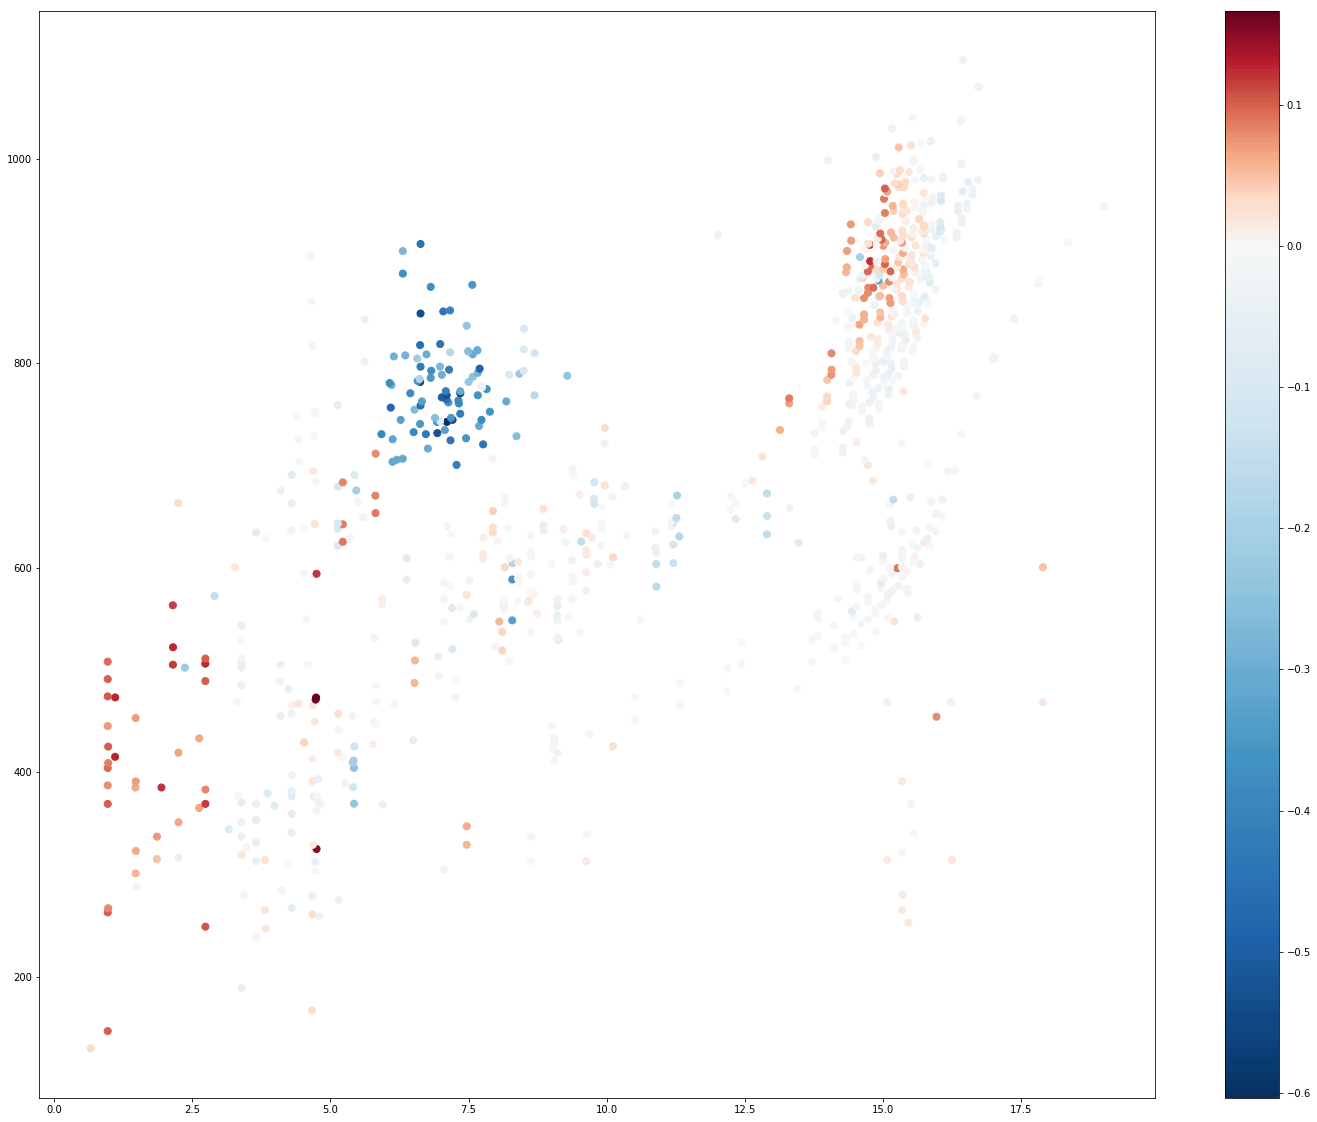

In [44]:
cmap = matplotlib.colors.ListedColormap(seaborn.color_palette("RdBu_r", 300).as_hex())
f, ax = plt.subplots()
points = ax.scatter(data_annot_norm['rt'], data_annot_norm['mz'], c=logfc_fat_meat, s=50, cmap=cmap, norm=MidpointNormalize(midpoint=0))
f.colorbar(points)
f.set_size_inches(25,20)


In [75]:
count_lipids(data_annot_norm['lm_id'][logfc_fat_meat<=logfc_fat_meat.quantile(0.02)]).most_common()

[('LMGP01030077', 2),
 ('LMGP01090010', 2),
 ('LMGP01020039', 2),
 ('LMGP01020216', 2),
 ('LMGP01020257', 2),
 ('LMGP02020044', 2),
 ('LMGP16010001', 2),
 ('LMGP01090012', 2),
 ('LMGP01080023', 2),
 ('LMGP02030071', 2),
 ('LMGP01030145', 2),
 ('LMGP01020041', 2),
 ('LMGP01020042', 2),
 ('LMGP01020015', 2),
 ('LMGP01090021', 2),
 ('LMGP01030134', 2),
 ('LMGP02020097', 2),
 ('LMGP01030053', 2),
 ('LMGP01090007', 2),
 ('LMGP02030072', 2),
 ('LMGP01030006', 2),
 ('LMGP01090009', 2),
 ('LMGP01030144', 2),
 ('LMGP01020195', 2),
 ('LMGP01090011', 2),
 ('LMGP02020070', 2),
 ('LMGP02030051', 2),
 ('LMGP01090019', 2),
 ('LMGP01030008', 2),
 ('LMGP02020065', 2),
 ('LMGP01030128', 2),
 ('LMGP01030135', 2),
 ('LMGP01020029', 2),
 ('LMGP01090006', 2),
 ('LMGP01020066', 1),
 ('LMGP03010305', 1),
 ('LMSP03020025', 1),
 ('LMGP01012192', 1),
 ('LMGP10010245', 1),
 ('LMGP02010501', 1),
 ('LMGP10010686', 1),
 ('LMGP02010776', 1),
 ('LMGP01011362', 1),
 ('LMGP01010586', 1),
 ('LMGP06010340', 1),
 ('LMGP020

In [71]:
mean_scat1_sample = data_annot_norm[select_columns(samples_columns, ["scat1"])].mean(axis=1)
mean_scat2_sample = data_annot_norm[select_columns(samples_columns, ["scat2"])].mean(axis=1)

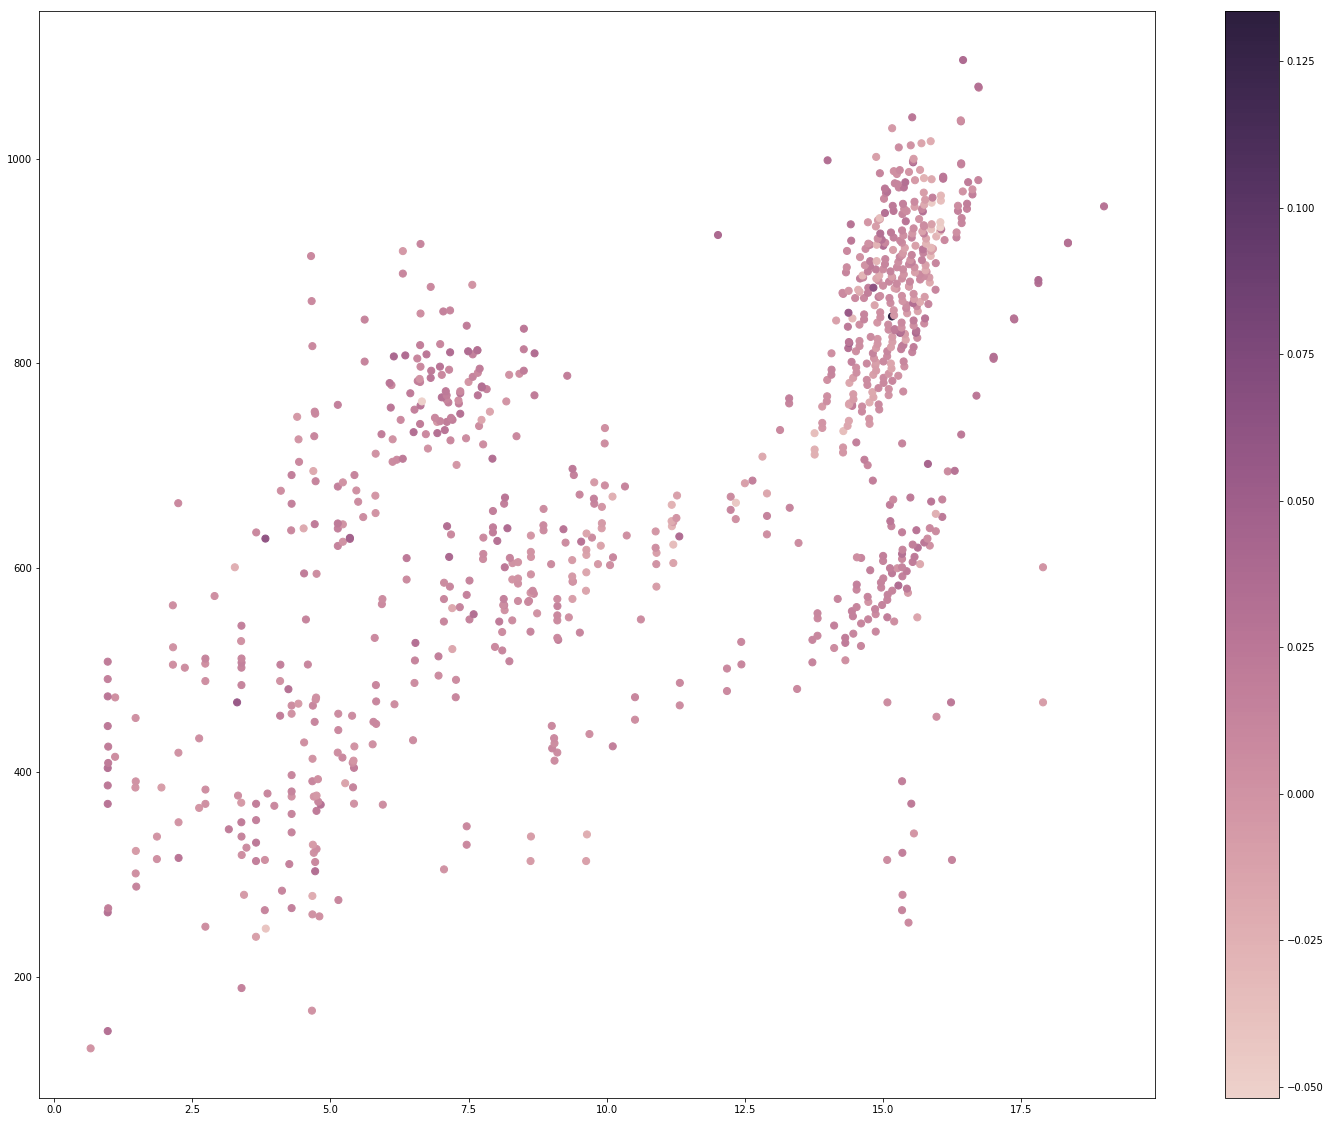

In [76]:
logfc_scat1_scat2 = np.log(mean_scat1_sample/mean_scat2_sample)

cmap = seaborn.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(data_annot_norm['rt'], data_annot_norm['mz'], c=logfc_scat1_scat2, s=50, cmap=cmap)
f.colorbar(points)
f.set_size_inches(25,20)
